## Preprocess Data

In [ ]:
import os
import pandas as pd
import torchaudio
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from google.colab import drive

#### Features and Labels

In [ ]:
# Set directory
drive.mount('/content/drive')
csv_path = "/content/drive/MyDrive/featuresAndLabels.csv"

# Load and clean the featuresAndLabels.csv
df = pd.read_csv(csv_path)
df.head()

Mounted at /content/drive


,clipName,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,tonnets_172,N,A,D,F,S,H,low,medium,high
0,1022_ITS_ANG_XX,-625.058655,-4.994524,-5.040599,31.118151,-11.813456,-14.570557,0.724647,-9.413414,-3.972650,...,0.009466,0.000000,0.454545,0.545455,0.0,0.0,0.0,0.000000,0.272727,0.727273
1,1037_ITS_ANG_XX,-648.157227,-10.045857,7.429339,20.802429,-12.531164,-11.790744,-3.735406,-6.268928,-9.658600,...,0.032486,0.500000,0.200000,0.200000,0.1,0.0,0.0,0.000000,0.300000,0.700000
2,1060_ITS_NEU_XX,-565.523743,-29.746906,5.289134,20.724148,-6.095077,-11.757398,0.216888,-9.311358,-4.887557,...,0.003219,0.900000,0.000000,0.000000,0.0,0.1,0.0,0.000000,0.200000,0.800000
3,1075_ITS_NEU_XX,-556.091248,-15.240954,11.779830,20.665905,-9.193678,-11.914318,0.438259,-7.635978,-7.933719,...,0.001605,0.909091,0.000000,0.090909,0.0,0.0,0.0,0.181818,0.090909,0.727273
4,1073_IOM_DIS_XX,-622.589111,-13.248747,4.246189,30.263844,-10.529772,-10.335563,1.289759,-11.116067,-5.185853,...,0.040066,0.300000,0.000000,0.600000,0.0,0.1,0.0,0.200000,0.200000,0.600000


In [ ]:
def get_max_value_and_column(row, columns):
    max_value = -1  # Initialize with a value smaller than any possible value
    max_column = ''
    for col in columns:
        if row[col] > max_value:
            max_value = row[col]
            max_column = col
    return max_value, max_column

# Apply the function to get the emotion column
emotion_columns = ['N','A','D','F','S','H']
df[['emotion_value','emotion']] = df.apply(lambda row: pd.Series(get_max_value_and_column(row, emotion_columns)), axis=1)

# Apply the function to get the strength column
strength_columns = ['low','medium','high']
df[['strength_value','strength']] = df.apply(lambda row: pd.Series(get_max_value_and_column(row, strength_columns)), axis=1)

def convert_emotion(emotion):
  emotion_mapping = {
      'N': 'neutral',
      'A': 'angry',
      'D': 'sad',
      'F': 'fear',
      'S': 'disgust',
      'H': 'happy'
  }
  return emotion_mapping.get(emotion, 'unknown')  # Return 'unknown' if emotion not found

# Example usage (assuming 'df' is your DataFrame)
df['emotion'] = df['emotion'].apply(convert_emotion)
df.head()

,clipName,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,medium,high,emotion_value,emotion,strength_value,strength,emotion_encoded,strength_encoded,audio_path,audio
0,1022_ITS_ANG_XX,-625.058655,-4.994524,-5.040599,31.118151,-11.813456,-14.570557,0.724647,-9.413414,-3.972650,...,0.272727,0.727273,0.545455,sad,0.727273,high,1,0,/content/drive/MyDrive/CREMA-D/1022_ITS_ANG_XX...,"[[tensor(0.0002), tensor(-0.0013), tensor(-0.0..."
1,1037_ITS_ANG_XX,-648.157227,-10.045857,7.429339,20.802429,-12.531164,-11.790744,-3.735406,-6.268928,-9.658600,...,0.300000,0.700000,0.500000,neutral,0.700000,high,4,0,/content/drive/MyDrive/CREMA-D/1037_ITS_ANG_XX...,"[[tensor(0.0002), tensor(0.0002), tensor(0.001..."
2,1060_ITS_NEU_XX,-565.523743,-29.746906,5.289134,20.724148,-6.095077,-11.757398,0.216888,-9.311358,-4.887557,...,0.200000,0.800000,0.900000,neutral,0.800000,high,4,0,/content/drive/MyDrive/CREMA-D/1060_ITS_NEU_XX...,"[[tensor(0.0317), tensor(0.0420), tensor(0.044..."
3,1075_ITS_NEU_XX,-556.091248,-15.240954,11.779830,20.665905,-9.193678,-11.914318,0.438259,-7.635978,-7.933719,...,0.090909,0.727273,0.909091,neutral,0.727273,high,4,0,/content/drive/MyDrive/CREMA-D/1075_ITS_NEU_XX...,"[[tensor(-0.0290), tensor(-0.0271), tensor(-0...."
4,1073_IOM_DIS_XX,-622.589111,-13.248747,4.246189,30.263844,-10.529772,-10.335563,1.289759,-11.116067,-5.185853,...,0.200000,0.600000,0.600000,sad,0.600000,high,1,0,/content/drive/MyDrive/CREMA-D/1073_IOM_DIS_XX...,"[[tensor(-0.0321), tensor(-0.0363), tensor(-0...."


In [ ]:
# Encode emotion labels
le_emotion = LabelEncoder()
df['emotion_encoded'] = le_emotion.fit_transform(df['emotion'])

# Encode strength labels
le_strength = LabelEncoder()
df['strength_encoded'] = le_strength.fit_transform(df['strength'])

df.head()

,clipName,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,medium,high,emotion_value,emotion,strength_value,strength,emotion_encoded,strength_encoded,audio_path,audio
0,1022_ITS_ANG_XX,-625.058655,-4.994524,-5.040599,31.118151,-11.813456,-14.570557,0.724647,-9.413414,-3.972650,...,0.272727,0.727273,0.545455,sad,0.727273,high,5,0,/content/drive/MyDrive/CREMA-D/1022_ITS_ANG_XX...,"[[tensor(0.0002), tensor(-0.0013), tensor(-0.0..."
1,1037_ITS_ANG_XX,-648.157227,-10.045857,7.429339,20.802429,-12.531164,-11.790744,-3.735406,-6.268928,-9.658600,...,0.300000,0.700000,0.500000,neutral,0.700000,high,4,0,/content/drive/MyDrive/CREMA-D/1037_ITS_ANG_XX...,"[[tensor(0.0002), tensor(0.0002), tensor(0.001..."
2,1060_ITS_NEU_XX,-565.523743,-29.746906,5.289134,20.724148,-6.095077,-11.757398,0.216888,-9.311358,-4.887557,...,0.200000,0.800000,0.900000,neutral,0.800000,high,4,0,/content/drive/MyDrive/CREMA-D/1060_ITS_NEU_XX...,"[[tensor(0.0317), tensor(0.0420), tensor(0.044..."
3,1075_ITS_NEU_XX,-556.091248,-15.240954,11.779830,20.665905,-9.193678,-11.914318,0.438259,-7.635978,-7.933719,...,0.090909,0.727273,0.909091,neutral,0.727273,high,4,0,/content/drive/MyDrive/CREMA-D/1075_ITS_NEU_XX...,"[[tensor(-0.0290), tensor(-0.0271), tensor(-0...."
4,1073_IOM_DIS_XX,-622.589111,-13.248747,4.246189,30.263844,-10.529772,-10.335563,1.289759,-11.116067,-5.185853,...,0.200000,0.600000,0.600000,sad,0.600000,high,5,0,/content/drive/MyDrive/CREMA-D/1073_IOM_DIS_XX...,"[[tensor(-0.0321), tensor(-0.0363), tensor(-0...."


#### Audio

In [ ]:
# Set audio directory
audio_dir = "/content/drive/MyDrive/CREMA-D"

# Load audio files with handling missing
def load_audio_files(audio_dir):
    file_paths = {}
    for fname in os.listdir(audio_dir):
        if fname.endswith('.wav'):
            clip_name = fname.replace('.wav', '')
            path = os.path.join(audio_dir, fname)
            try:
                waveform, sample_rate = torchaudio.load(path)
                file_paths[clip_name] = waveform
            except Exception as e:
                print(f"Error loading {path}: {e}")
    return file_paths
    print(f"Loaded {len(file_paths)} audio files.")

In [ ]:
# Load audio and map to dataframe
audio_data = load_audio_files(audio_dir)
df['audio_path'] = df['clipName'].apply(lambda x: os.path.join(audio_dir, x + '.wav'))
df['audio'] = df['clipName'].map(audio_data)
df = df[df['audio'].apply(lambda x: isinstance(x, torch.Tensor) or (isinstance(x, list) and torch.is_tensor(x[0])))]

# Display data
df.head()

,clipName,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,medium,high,emotion_value,emotion,strength_value,strength,emotion_encoded,strength_encoded,audio_path,audio
0,1022_ITS_ANG_XX,-625.058655,-4.994524,-5.040599,31.118151,-11.813456,-14.570557,0.724647,-9.413414,-3.972650,...,0.272727,0.727273,0.545455,sad,0.727273,high,5,0,/content/drive/MyDrive/CREMA-D/1022_ITS_ANG_XX...,"[[tensor(0.0002), tensor(-0.0013), tensor(-0.0..."
1,1037_ITS_ANG_XX,-648.157227,-10.045857,7.429339,20.802429,-12.531164,-11.790744,-3.735406,-6.268928,-9.658600,...,0.300000,0.700000,0.500000,neutral,0.700000,high,4,0,/content/drive/MyDrive/CREMA-D/1037_ITS_ANG_XX...,"[[tensor(0.0002), tensor(0.0002), tensor(0.001..."
2,1060_ITS_NEU_XX,-565.523743,-29.746906,5.289134,20.724148,-6.095077,-11.757398,0.216888,-9.311358,-4.887557,...,0.200000,0.800000,0.900000,neutral,0.800000,high,4,0,/content/drive/MyDrive/CREMA-D/1060_ITS_NEU_XX...,"[[tensor(0.0317), tensor(0.0420), tensor(0.044..."
3,1075_ITS_NEU_XX,-556.091248,-15.240954,11.779830,20.665905,-9.193678,-11.914318,0.438259,-7.635978,-7.933719,...,0.090909,0.727273,0.909091,neutral,0.727273,high,4,0,/content/drive/MyDrive/CREMA-D/1075_ITS_NEU_XX...,"[[tensor(-0.0290), tensor(-0.0271), tensor(-0...."
4,1073_IOM_DIS_XX,-622.589111,-13.248747,4.246189,30.263844,-10.529772,-10.335563,1.289759,-11.116067,-5.185853,...,0.200000,0.600000,0.600000,sad,0.600000,high,5,0,/content/drive/MyDrive/CREMA-D/1073_IOM_DIS_XX...,"[[tensor(-0.0321), tensor(-0.0363), tensor(-0...."


In [ ]:
!pip install librosa
import librosa

audio_path = "/content/drive/MyDrive/CREMA-D/1091_WSI_HAP_XX.wav"
audio, rate = librosa.load(audio_path, sr=16000)
print(f"Sampling rate: {rate}")

Sampling rate: 16000


In [ ]:
inputs = feature_extractor(audio, sampling_rate=rate, return_tensors="pt", padding=True)
print(f"Input values shape: {inputs.input_values.shape}")
# Print some values from inputs.input_values to inspect the features
print(f"Input values (example): {inputs.input_values[0, :10]}")

Input values shape: torch.Size([1, 34701])
Input values (example): tensor([-0.1165, -0.0960, -0.1196, -0.1117, -0.1056, -0.0881, -0.1165, -0.1040,
        -0.1149, -0.1180])


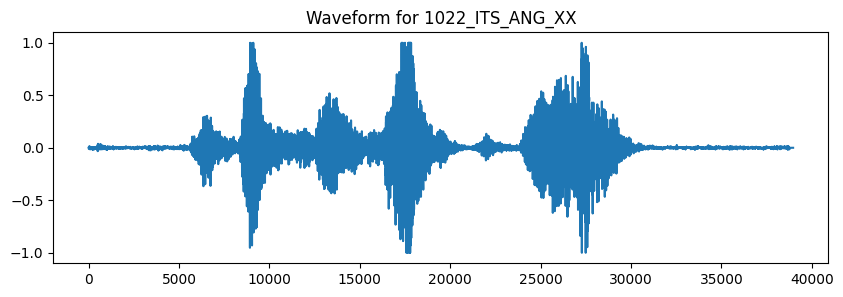

In [ ]:
import matplotlib.pyplot as plt

waveform = df.iloc[0]['audio'][0]
plt.figure(figsize=(10, 3))
plt.plot(waveform.numpy())
plt.title(f"Waveform for {df.iloc[0]['clipName']}")
plt.show()

## Model

We're using a pre-trained model derived from Wave2Vec called [wav2vec-english-speech-emotion-recognition](https://huggingface.co/r-f/wav2vec-english-speech-emotion-recognition)


**Parameters:**

learning_rate: 0.0001

train_batch_size: 4

eval_batch_size: 4

eval_steps: 500

seed: 42

gradient_accumulation_steps: 2

optimizer: Adam with betas=(0.9,0.999) and epsilon=1e-08

num_epochs: 4

max_steps=7500

save_steps: 1500

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("r-f/wav2vec-english-speech-emotion-recognition")
model = Wav2Vec2ForSequenceClassification.from_pretrained("r-f/wav2vec-english-speech-emotion-recognition")
model.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at r-f/wav2vec-english-speech-emotion-recognition and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=

In [ ]:
# Model emotion encoding
print(model.config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [ ]:
emotion_mapping = dict(zip(le_emotion.classes_, le_emotion.transform(le_emotion.classes_)))

# Print the mapping
for emotion, encoded_value in emotion_mapping.items():
    print(f"{emotion}: {encoded_value}")

mapping_df = pd.DataFrame(list(emotion_mapping.items()), columns=['Emotion', 'Encoded Value'])
print(mapping_df)

angry: 0
disgust: 1
fear: 2
happy: 3
neutral: 4
sad: 5
   Emotion  Encoded Value
0    angry              0
1  disgust              1
2     fear              2
3    happy              3
4  neutral              4
5      sad              5


### Emotion Prediction

In [ ]:
def predict_emotion(audio_path):
    try:
        audio, rate = librosa.load(audio_path, sr=16000)
        inputs = feature_extractor([audio], sampling_rate=rate, return_tensors="pt", padding=True)

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_label = torch.argmax(predictions, dim=-1)

            if 0 <= predicted_label.item() < len(model.config.id2label):
                emotion = model.config.id2label[predicted_label.item()]
            else:
                emotion = "unknown"
                print(f"[WARNING] Label {predicted_label.item()} is out of range.")
        return emotion
    except Exception as e:
        print(f"[ERROR] {audio_path}: {e}")
        return "error"

# test
emotion = predict_emotion("/content/drive/MyDrive/CREMA-D/1091_WSI_HAP_XX.wav")
print(f"Predicted emotion: {emotion}")


Predicted emotion: fear


In [ ]:
!pip install tqdm
import tqdm
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

def predict_emotion(audio_path):
    try:
        audio, rate = librosa.load(audio_path, sr=16000)
        inputs = feature_extractor([audio], sampling_rate=rate, return_tensors="pt", padding=True)

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_label = torch.argmax(predictions, dim=-1)

            if 0 <= predicted_label.item() < len(model.config.id2label):
                return model.config.id2label[predicted_label.item()]
            else:
                return "unknown"
    except:
        return "error"

tqdm.pandas()
df['predicted_emotion'] = df['audio_path'].progress_apply(predict_emotion)

100%|██████████| 2070/2070 [1:08:09<00:00,  1.98s/it]


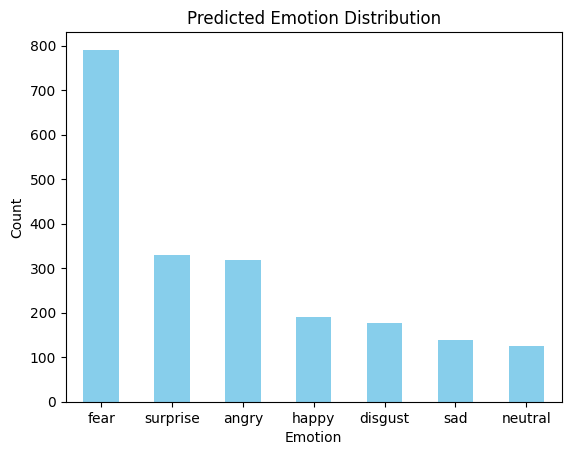

In [ ]:
df['predicted_emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Predicted Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

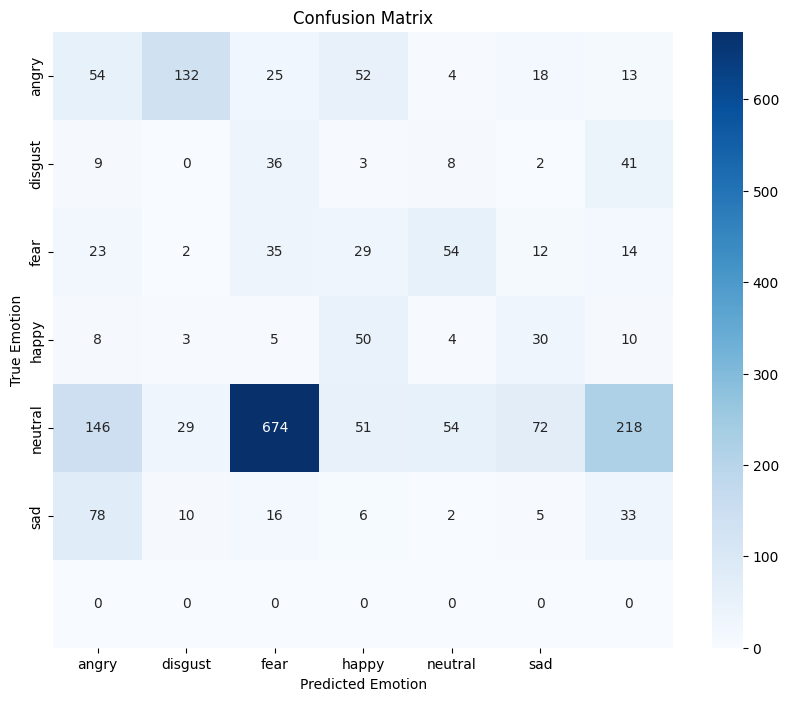

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'df' contains 'emotion' (true labels) and 'predicted_emotion' (predictions)
cm = confusion_matrix(df['emotion'], df['predicted_emotion'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_emotion.classes_, yticklabels=le_emotion.classes_)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Confusion Matrix")
plt.show()

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(df['emotion'], df['predicted_emotion'], average=None)
recall = recall_score(df['emotion'], df['predicted_emotion'], average=None)
f1 = f1_score(df['emotion'], df['predicted_emotion'], average=None)

emotions = le_emotion.classes_

for i in range(len(emotions)):
    print(f"Emotion: {emotions[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-score: {f1[i]}")
    print("---")


Emotion: angry
  Precision: 0.16981132075471697
  Recall: 0.18120805369127516
  F1-score: 0.17532467532467533
---
Emotion: disgust
  Precision: 0.0
  Recall: 0.0
  F1-score: 0.0
---
Emotion: fear
  Precision: 0.04424778761061947
  Recall: 0.20710059171597633
  F1-score: 0.07291666666666667
---
Emotion: happy
  Precision: 0.2617801047120419
  Recall: 0.45454545454545453
  F1-score: 0.33222591362126247
---
Emotion: neutral
  Precision: 0.42857142857142855
  Recall: 0.04340836012861737
  F1-score: 0.07883211678832117
---
Emotion: sad
  Precision: 0.03597122302158273
  Recall: 0.03333333333333333
  F1-score: 0.03460207612456748
---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Strength Prediction

In [43]:
!pip install transformers  # Install transformers if not already installed

import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor

# Load pre-trained model and feature extractor
feature_extractor_strength = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
model_strength = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=3)

# Set the model to evaluation mode
model_strength.eval()

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [44]:
def predict_strength(audio_path):
    try:
        audio, rate = librosa.load(audio_path, sr=16000)
        inputs = feature_extractor_strength([audio], sampling_rate=rate, return_tensors="pt", padding=True)

        with torch.no_grad():
            outputs = model_strength(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_label = torch.argmax(predictions, dim=-1)

            # Map predicted label to strength level
            strength_mapping = {
                0: 'low',
                1: 'medium',
                2: 'high'
              }
            return strength_mapping.get(predicted_label.item(), 'unknown')
    except Exception as e:
        print(f"[ERROR] {audio_path}: {e}")
        return "error"

# test
strength = predict_strength("/content/drive/MyDrive/CREMA-D/1091_WSI_HAP_XX.wav")
print(f"Predicted strength: {strength}")

Predicted strength: medium


In [45]:
def predict_strength(audio_path):
    try:
        audio, rate = librosa.load(audio_path, sr=16000)
        inputs = feature_extractor([audio], sampling_rate=rate, return_tensors="pt", padding=True)

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_label = torch.argmax(predictions, dim=-1)

            # Map predicted label to strength level
            strength_mapping = {
                0: 'low',
                1: 'medium',
                2: 'high'
              }
            return strength_mapping.get(predicted_label.item(), 'unknown')
    except Exception as e:
        print(f"[ERROR] {audio_path}: {e}")
        return "error"

tqdm.pandas()
df['predicted_strength'] = df['audio_path'].progress_apply(predict_strength)

100%|██████████| 2070/2070 [1:12:45<00:00,  2.11s/it]


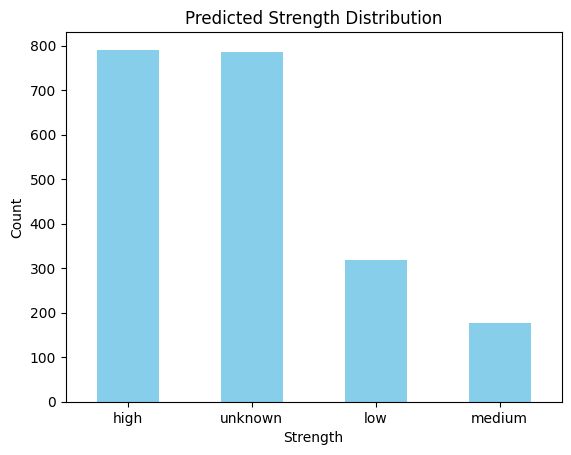

In [46]:
import matplotlib.pyplot as plt
df['predicted_strength'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Predicted Strength Distribution")
plt.xlabel("Strength")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

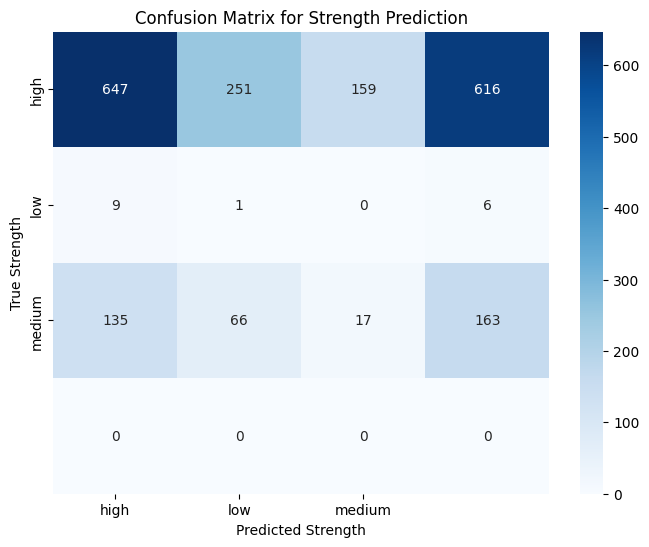

In [47]:
import matplotlib.pyplot as plt
# Assuming 'df' contains 'strength' (true labels) and 'predicted_strength' (predictions)
cm_strength = confusion_matrix(df['strength'], df['predicted_strength'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_strength, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_strength.classes_, yticklabels=le_strength.classes_)
plt.xlabel("Predicted Strength")
plt.ylabel("True Strength")
plt.title("Confusion Matrix for Strength Prediction")
plt.show()

In [50]:
precision = precision_score(df['strength'], df['predicted_strength'], average=None)
recall = recall_score(df['strength'], df['predicted_strength'], average=None)
f1 = f1_score(df['strength'], df['predicted_strength'], average=None)

strength = le_strength.classes_

for i in range(len(strength)):
    print(f"Strength: {strength[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-score: {f1[i]}")
    print("---")

Strength: high
  Precision: 0.8179519595448799
  Recall: 0.38673042438732813
  F1-score: 0.5251623376623377
---
Strength: low
  Precision: 0.0031446540880503146
  Recall: 0.0625
  F1-score: 0.005988023952095809
---
Strength: medium
  Precision: 0.09659090909090909
  Recall: 0.04461942257217848
  F1-score: 0.06104129263913824
---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
